#  Hidden Markov Model with Gaussian-distributed observed variables

The aim of this notebook is to implement the EM algorithm of an HMM with multinomial latent variable and Gaussian-distributed observed variables.

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import random, seed
from scipy.stats import norm
from io import StringIO

In [2]:
%config InlineBackend.figure_format = "retina"

Let ${\bf X}=\{{\bf x}_n \vert {\bf x}_n \in \mathbb{R}^M\}_{n=1}^N$ be an sequential dataset of observed variables. We define a Hidden Markov Model (HMM) by introducing a set of unobserved (latent) variables ${\bf Z}=\{{\bf z}_n\}_{n=1}^N$. We define the relationship between ${\bf X}$ and ${\bf Z}$ as the following graph:

![Hidden Markov Model](https://imgur.com/1YC0iu0.png)

The joint distribution of an HMM is given by

$$
    p({\bf x}_1, \ldots, {\bf x}_n, {\bf z}_1, {\bf z}_N) = p({\bf z}_1)\prod_{n=1}^N p({\bf z}_n\vert {\bf z}_{n-1})\prod_{n=1}^N p({\bf x}_n \vert {\bf z}_n)
$$

With 

$$
    p({\bf z}_1\vert\boldsymbol\pi) = \prod_{k=1}^K \pi_k^{z_{1k}}
$$

We define the *emission* probabilities as

$$
p({\bf x}_n\vert {\bf z}_n, \boldsymbol\phi) = \prod_{k=1}^K p({\bf x}_n\vert\phi_k)^{z_{nk}} = \prod_{k=1}^K \left(\mathcal{N}({\bf x}_n\vert \boldsymbol\mu_k, \boldsymbol\Sigma_k)\right)^{z_{nk}}
$$

## HMM via the EM algorithm

In order to find the values $\boldsymbol\theta = \{\boldsymbol\pi, A, \boldsymbol\phi\}$, we make use of the EM algorithm. We perform a step of the EM algorith for an HMM as follows:

* **E-Step**: Compute $p({\bf Z}\vert{\bf X}, \boldsymbol\theta)$
* **M-Step**: Find $\boldsymbol\theta^{\text{new}}=\arg\max_{\boldsymbol\theta} Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}})$.

----

By writing the expected complete-data log-likelihood, we obtain an expression of the form

$$
   Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}}) = \sum_{k=1}^K \log\pi_k \gamma(z_{1k}) + \sum_{n=2}^N\sum_{j=1}^K\sum_{k=1}^K \xi(z_{n-1,j}, z_{n,k}) \log A_{jk} + \sum_{n=1}^N\sum_{k=1}^K \log p({\bf x}_n\vert\phi_k) \gamma(z_{nk})
$$

With updating equations


### E-Step

* $\gamma(z_{nk}) = \mathbb{E}[z_{nk}]$
* $\xi(z_{n-1,j}, z_{n,k}) = \mathbb{E}[z_{n-1, j} \cdot z_{n,k}]$

### M-Step

The M-step updating equations become

$$
    \pi_k = \frac{\gamma(z_{1k})}{\sum_{j=1}^K \gamma(z_{1j})}
$$


$$
    A_{jk} = \frac{\sum_{n=2}^N \xi(z_{n-1, k}, z_{nk})}{\sum_{l=1}^K\sum_{n=2}^N \xi(z_{n-1, k}, z_{nl})}
$$

To compute $\forall n,k,k:\gamma(z_{nk}), \xi(z_{n-1, j}, z_{nk})$, we require to obtain the values for

$$
    \gamma({\bf z}_n) = \frac{ \alpha({\bf z}_n)\beta({\bf z}_n) }{p({\bf X})}
$$

$$
    \xi({\bf z}_{n-1}, {\bf z}_n) = \frac{\alpha({\bf z}_{n-1}) p({\bf x}_n\vert {\bf z}_n) p({\bf z}_{n-1}\vert {\bf z}_n) \beta({\bf z}_n)}{p({\bf X})}
$$


Where $\alpha({\bf z}_n)$ and $\beta({\bf z})$ are recursive relations of the form

$$
    \alpha({\bf z}_n) = p({\bf x}_n\vert{\bf z}_n)\sum_{{\bf z}_{n-1}} \alpha({\bf z}_{n-1})p({\bf z}_n\vert {\bf z}_{n-1})
$$

$$
    \beta({\bf z}_n) = \sum_{{\bf z}_{n+1}} p({\bf x}_{n+1}\vert{\bf z}_{n+1})p({\bf z}_{n+1} \vert {\bf z}_n)
$$


With initial conditions

* $\alpha(z_{1k}) = \pi_k p(x_1\vert\phi_k)$
* $\beta(z_{Nk}) = 1$

$\alpha$ and $\beta$ are respectively known as the *Forward Message Passing* and *Backwards Message Passing*

### Modeling spread between MXN and BRL

* <strong style="color:crimson">Note</strong>: This is not a perfect example to use an HMM, as the bimodality in the distribution appears to correspond to different time periods and are not time indepenent.

In [3]:
def download_fx_daily(from_symbol, to_symbol, api_key):
    """
    Download the historical data of to_symbol currency
    in terms of from_symbol.
    
    Obtain your api from
            https://www.alphavantage.co/support/#api-key
    """
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "FX_DAILY",
        "from_symbol": from_symbol,
        "to_symbol": to_symbol,
        "outputsize": "full",
        "datatype": "csv",
        "apikey": api_key
    }
    
    r = requests.get(url, params=params)
    df = pd.read_csv(StringIO(r.text), index_col=0)
    df = df.set_index(pd.to_datetime(df.index)).sort_index()
    
    return df

In [4]:
apikey = os.environ["AVANTAGE_API"]
df_mxn = download_fx_daily("GBP", "MXN", apikey)
df_brl = download_fx_daily("EUR", "MXN", apikey)

In [5]:
df = (df_mxn - df_brl).dropna()

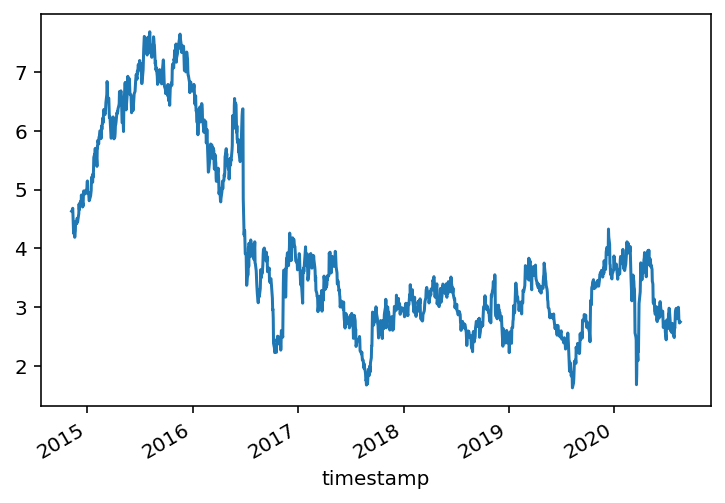

In [6]:
df["close"].plot()

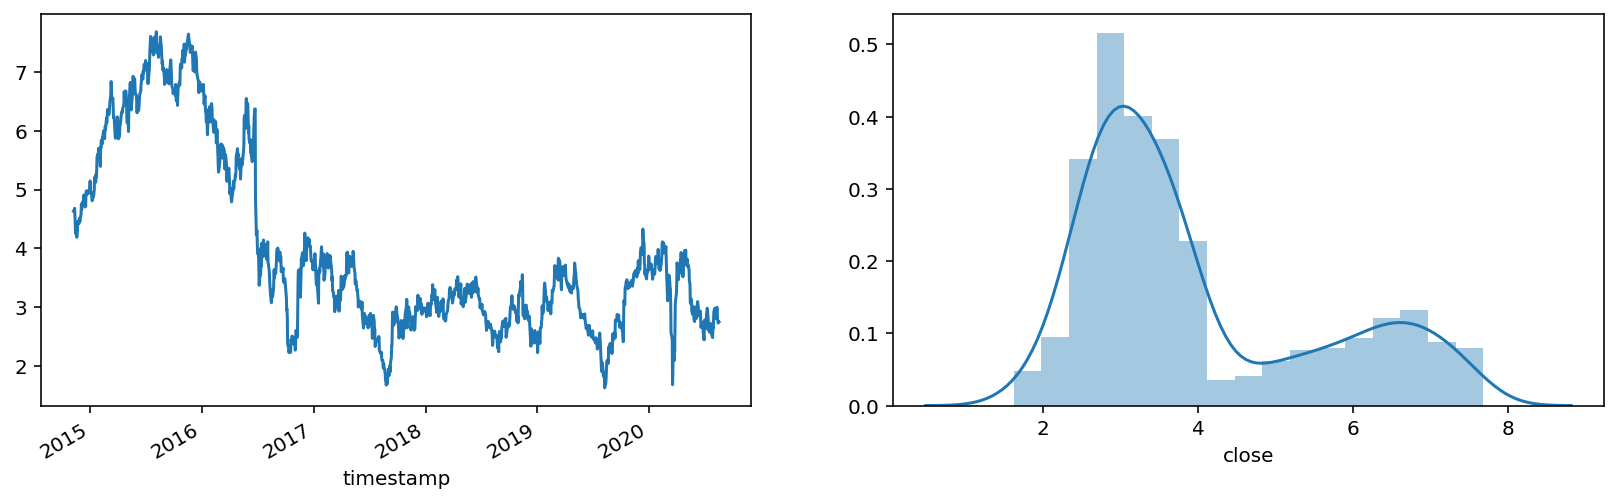

In [7]:
df_mxn_brl = df["close"]
N, *_ = df_mxn_brl.shape

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df_mxn_brl.plot(ax=ax[0])
sns.distplot(df_mxn_brl, ax=ax[1])

In [8]:
X = df_mxn_brl.copy()

## The E-Step

In [9]:
seed(314)

K = 3
# initial parameters for the latent variables
pi = random(K)
pi = pi / pi.sum()
A = random((K, K))
A = A / A.sum(axis=1, keepdims=True)

# Initial parameters for the observed distribution
mus = random(K)
sigmas = random(K)

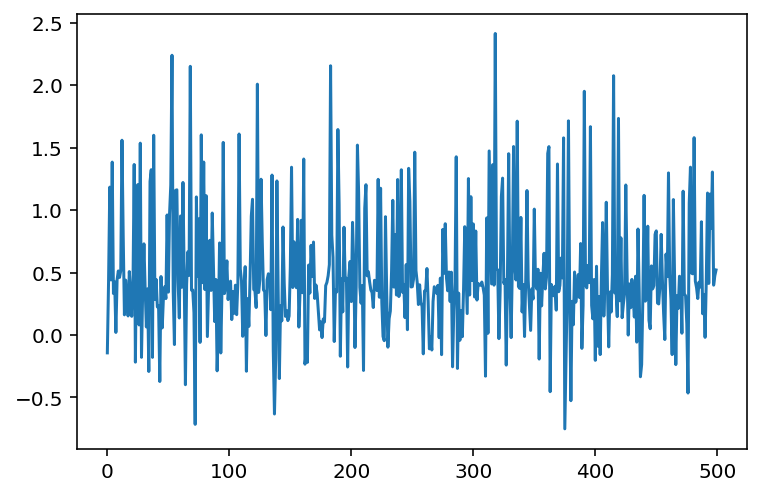

In [10]:
# Simulation before parameter learning
z = np.arange(K)

seed(314)
n_samples = 500
samples = np.zeros(n_samples)
zi = np.random.choice(z, p=pi)

for n in range(n_samples):
    Nx = norm(loc=mus[zi], scale=sigmas[zi])
    samples[n] = Nx.rvs()
    
    zi = np.random.choice(z, p=A[zi])

plt.plot(samples)

#### Forward message-passsing

$$
    \alpha({\bf z}_n) = p({\bf x}_n\vert{\bf z}_n)\sum_{{\bf z}_{n-1}} \alpha({\bf z}_{n-1})p({\bf z}_n\vert {\bf z}_{n-1})
$$

* $\alpha(z_{1k}) = \pi_k p(x_1\vert\phi_k)$

In [42]:
Nx = norm(loc=mus * 10, scale=sigmas * 100)

In [43]:
# Initial "message"
a1 = pi * Nx.pdf(X.iloc[0])

# Second "message"
a2 = Nx.pdf(X.iloc[1]) * (a1[:, None] * A).sum(axis=0)

# third message
a3 = Nx.pdf(X.iloc[2]) * (a2[:, None] * A).sum(axis=0)

In general, we can write the forward message passing as follows:

In [44]:
alpha_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X.iteritems()):
    if n == 0:
        an = pi * Nx.pdf(xn)
    else:
        an = Nx.pdf(xn) * (an[:, None] * A).sum(axis=0)
    alpha_values[n] = an

In [45]:
alpha_values

array([[7.37134716e-03, 1.88535172e-02, 9.41670070e-04],
       [1.38003732e-04, 3.29998000e-04, 7.32785098e-05],
       [2.61837099e-06, 7.87247875e-06, 1.37363712e-06],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

#### Backward message-passsing

$$
    \beta({\bf z}_n) = \sum_{{\bf z}_{n+1}} \beta({\bf z}_{n+1})  p({\bf x}_{n+1}\vert{\bf z}_{n+1}) p({\bf z}_{n+1}\vert {\bf z}_{n})
$$

* $\beta(z_{Nk}) = 1$

In [46]:
# final message
b1 = np.ones(K)

# final - 1 message
b2 = (b1 * Nx.pdf(X.iloc[-2]) * A).sum(axis=1)

In general, we can write the backward message passing as follows:

In [47]:
beta_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X[::-1].shift(1).iteritems()):
    if n == 0:
        bn = 1
    else:
        bn = (bn * Nx.pdf(xn) * A).sum(axis=1)
    
    beta_values[n] = bn

beta_values = beta_values[::-1]

In [48]:
beta_values

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.28583568e-04, 3.86529599e-04, 6.69398672e-04],
       [2.69453032e-02, 1.62211118e-02, 3.76801017e-02],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

#### The likelihood $p(X)$

Once obtained $\forall n: \alpha({\bf z}_n), \beta({\bf z}_n)$, we can compute the likelihood $p({\bf X})$ in the form

$$
    p({\bf X}) = \sum_{{\bf z}_n} \alpha({\bf z}_n) \beta({\bf z}_n)
$$

Or, more specifically,

$$
    p({\bf X}) = \sum_{{\bf z}_N} \alpha({\bf z}_N)
$$

In [49]:
alpha_values[-1].sum()

0.0

In [50]:
(alpha_values[2] * beta_values[2]).sum()

0.0

In [51]:
(alpha_values[100] * beta_values[100]).sum()

0.0

In [52]:
likelihood = alpha_values[-1].sum()

#### $\gamma$, $\xi$ values

With $\alpha({\bf z}_n)$, $\beta({\bf z}_n)$, and $p({\bf X})$, we can write 

$$
    \gamma({\bf z}_n) = \frac{\alpha({\bf z}_n) \beta({\bf z}_n)}{p({\bf X})}
$$

$$
    \xi({\bf z}_{n-1}, {\bf z}_n) = \frac{\alpha({\bf z}_{n-1}) p({\bf x}_n\vert {\bf z}_n) p({\bf z}_n\vert {\bf z}_{n-1})\beta({\bf z}_n)}{p(\bf X)}
$$

In [53]:
# p(xn|zn) # to-do: optimize for-loop
p_xz = np.r_[[Nx.pdf(x) for x in X]]

gamma = alpha_values * beta_values / likelihood
xi = (alpha_values[:-1][..., None] * p_xz[1:, None, :] * A[None, ...] * beta_values[1:, None, :]) / likelihood

/Users/gerardoduran/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/gerardoduran/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [54]:
gamma

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

## The M-step

Once obtained the values $\gamma({\bf z}_n)$ and $\xi({\bf z}_{n-1}, {\bf z}_n)$, we proceed by updating our parameters $\pi_k$, $A_{jk}$, $\boldsymbol\mu_k$, $\boldsymbol\Sigma_k$

### Latent parameters update
---

#### Updating $\pi_k$

The updating equation for $\pi_k$ take the form

$$
    \pi_k = \frac{\gamma(z_{1k})}{\sum_{j=1}^K \gamma(z_{1j})}
$$

In [205]:
# Note that Bishop makes the summation explicit, but there is
# no need for this, as γ(nk) is a pmf for fixed n and varying k
pi = gamma[0] / gamma[0].sum()
pi

array([0.39444062, 0.54791066, 0.05764873])

#### Updating $A_{jk}$




$$
    A_{jk} = \frac{\sum_{n=2}^N \xi(z_{n-1, k}, z_{nk})}{\sum_{l=1}^K\sum_{n=2}^N \xi(z_{n-1, k}, z_{nl})}
$$

In [22]:
A = xi.sum(axis=0) / xi.sum(axis=0).sum(axis=1, keepdims=True)
A

array([[0.09841319, 0.90158681],
       [0.26353114, 0.73646886]])

### Observed variables' parameters update
---

#### Updating $\mu_k$

The updating equation for $\mu_k$ take the form

$$
    \mu_{ik} = \frac{\sum_{n=1}^N \gamma(z_{nk}) {\bf x}_n}{\sum_{n=1}^N \gamma(z_{nk})}
$$

In [23]:
mus = (gamma* X[:, None]).sum(axis=0) / gamma.sum(axis=0)
mus

array([0.22589915, 0.22579282])

#### Updating $\Sigma_k$

$$
    \Sigma_{k} = \frac{\sum_{n=1}^N \gamma(z_{nk}) ({\bf x}_n - \mu_k)({\bf x}_n - \mu_k)^T}{\sum_{n=1}^N \gamma(z_{nk})}
$$

In [24]:
diff = X[:, None] - mus[None, :]
# The generalized version of this computation can be written in the form
sigmas = np.einsum("ni,nik,nil->i", gamma, diff[..., None], diff[..., None]) / gamma.sum(axis=0)
# for x in R, this is the same as
sigmas = (gamma * diff ** 2).sum(axis=0) / gamma.sum(axis=0)

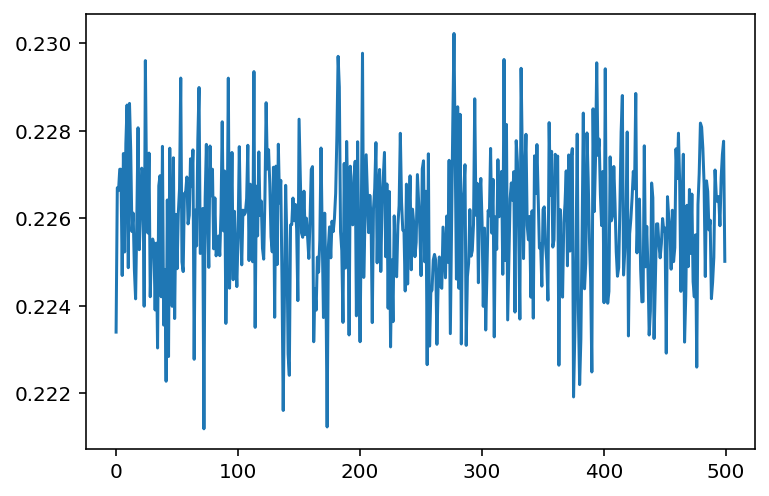

In [28]:
# Simulation before parameter learning
z = np.arange(K)

seed(314)
n_samples = 500
samples = np.zeros(n_samples)
zi = np.random.choice(z, p=pi)

for n in range(n_samples):
    Nx = norm(loc=mus[zi], scale=sigmas[zi])
    samples[n] = Nx.rvs()
    
    zi = np.random.choice(z, p=A[zi])

plt.plot(samples)

### The next round

The next round of the EM algorithm suffers the fact that the $\alpha$-terms become exponentially small.

In [29]:
Nx = norm(loc=mus, scale=sigmas)
alpha_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X.iteritems()):
    if n == 0:
        an = pi * Nx.pdf(xn)
    else:
        an = Nx.pdf(xn) * (an[:, None] * A).sum(axis=0)
    if np.isinf(an).any():
        break
    alpha_values[n] = an

In [30]:
alpha_values

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [31]:
alpha_values[n-2]

array([0., 0.])

In [32]:
beta_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X[::-1].shift(1).iteritems()):
    if n == 0:
        bn = 1
    else:
        bn = (bn * Nx.pdf(xn) * A).sum(axis=1)
    
    beta_values[n] = bn

beta_values = beta_values[::-1]

In [33]:
beta_values

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [1., 1.]])

# Handling small coefficients

The normalized version of $\alpha$ takes the form

$$
    \hat\alpha({\bf z}_n) = \frac{\alpha({\bf z}_n)}{p({\bf x}_1, \ldots, {\bf x}_n)}
$$

Introducing scaling factors of the form

$$
    c_n = p({\bf x}_n \vert {\bf x}_1, \ldots, {\bf x}_{n-1}),
$$

we see that

$$
    p({\bf x}_1, \ldots, {\bf x}_n) = \prod_{m=1}^n c_m
$$

In [55]:
seed(314)

K = 3
# initial parameters for the latent variables
pi = random(K)
pi = pi / pi.sum()
A = random((K, K))
A = A / A.sum(axis=1, keepdims=True)

# Initial parameters for the observed distribution
mus = -random(K)
sigmas = random(K)

In [56]:
Nx = norm(loc=mus, scale=sigmas * 40)

In [57]:
c1 = (pi * Nx.pdf(X[0])).sum()

In [58]:
# Initial "message"
a1 = pi * Nx.pdf(X.iloc[0])

# Second "message"
a2 = Nx.pdf(X.iloc[1]) * (a1[:, None] * A).sum(axis=0)

# third message
a3 = Nx.pdf(X.iloc[2]) * (a2[:, None] * A).sum(axis=0)

In [59]:
ahat_1 = a1 / c1

In [60]:
ahat_2 = Nx.pdf(X.iloc[1]) * (ahat_1 * A).sum(axis=0)
c2 = ahat_2.sum()
ahat_2 = ahat_2 / c2

In [61]:
ahat_3 = Nx.pdf(X.iloc[2]) * (ahat_2 * A).sum(axis=0)
c3 = ahat_3.sum()
ahat_3 = ahat_3 / c3

In [62]:
Nx.pdf(X.iloc[1]) * (ahat_1 * A).sum(axis=0)

array([0.01726365, 0.01015088, 0.00124608])

In [63]:
Nx = norm(loc=mus, scale=sigmas)
alpha_hat_values = np.zeros((N, K))
c_terms = np.zeros(N)

for n, (_, xn) in enumerate(X.iteritems()):
    if n == 0:
        ahat_n = pi * Nx.pdf(xn)
    else:
        ahat_n = Nx.pdf(xn) * (ahat_n[:, None] * A).sum(axis=0)
        
    cn = ahat_n.sum()    
    ahat_n = ahat_n / cn
    alpha_hat_values[n] = ahat_n
    c_terms[n] = cn

In [64]:
##### hat beta estimation #####

In [65]:
bhat_1 = np.ones(K) / c_terms[-1]
bhat_1

array([73956861.06618792, 73956861.06618792, 73956861.06618792])

In [66]:
beta_hat_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X[::-1].shift(1).iteritems()):
    cn = c_terms[-n]
    if n == 0:
        bhat_n = 1 
    else:
        bhat_n = (bhat_n * Nx.pdf(xn) * A).sum(axis=1) / cn
    
    bhat_n = bhat_n 
    beta_hat_values[n] = bhat_n 

beta_hat_values = beta_hat_values[::-1]

In [67]:
p_xz = np.r_[[Nx.pdf(x) for x in X]]
gamma = alpha_hat_values * beta_hat_values

xi = (1
    / c_terms[1:, None, None]
    * alpha_hat_values[:-1][..., None]
    * p_xz[1:, None, :] * A[None, ...]
    * beta_hat_values[1:, None, :])

## All together

In [80]:
pi = gamma[0] / gamma[0].sum()
pi

array([0., 0., 1.])

In [81]:
A = xi.sum(axis=0) / xi.sum(axis=0).sum(axis=1, keepdims=True)
A

array([[1.43304228e-004, 9.18072376e-175, 9.99856696e-001],
       [3.83182293e-004, 0.00000000e+000, 9.99616818e-001],
       [1.71475409e-008, 7.73021873e-176, 9.99999983e-001]])

In [82]:
mus = (gamma* X[:, None]).sum(axis=0) / gamma.sum(axis=0)
mus

array([1.70802705, 1.6276    , 3.97477388])

In [83]:
diff = X[:, None] - mus[None, :]
# The generalized version of this computation can be written in the form
sigmas = np.einsum("ni,nik,nil->i", gamma, diff[..., None], diff[..., None]) / gamma.sum(axis=0)
# for x in R, this is the same as
sigmas = (gamma * diff ** 2).sum(axis=0) / gamma.sum(axis=0)
sigmas = np.sqrt(sigmas)

sigmas

array([0.04708149, 0.        , 1.54232844])

In [84]:
Nx = norm(loc=mus, scale=sigmas)

In [85]:
alpha_hat_values = np.zeros((N, K))
c_terms = np.zeros(N)

for n, (_, xn) in enumerate(X.iteritems()):
    if n == 0:
        ahat_n = pi * Nx.pdf(xn)
    else:
        ahat_n = Nx.pdf(xn) * (ahat_n[:, None] * A).sum(axis=0)
        
    cn = ahat_n.sum()    
    ahat_n = ahat_n / cn
    alpha_hat_values[n] = ahat_n
    c_terms[n] = cn

/Users/gerardoduran/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/gerardoduran/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [86]:
beta_hat_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X[::-1].shift(1).iteritems()):
    cn = c_terms[-n]
    if n == 0:
        bhat_n = 1 
    else:
        bhat_n = (bhat_n * Nx.pdf(xn) * A).sum(axis=1) / cn
    
    bhat_n = bhat_n 
    beta_hat_values[n] = bhat_n 

beta_hat_values = beta_hat_values[::-1]

In [87]:
p_xz = np.r_[[Nx.pdf(x) for x in X]]
gamma = alpha_hat_values * beta_hat_values

xi = (1
    / c_terms[1:, None, None]
    * alpha_hat_values[:-1][..., None]
    * p_xz[1:, None, :] * A[None, ...]
    * beta_hat_values[1:, None, :])

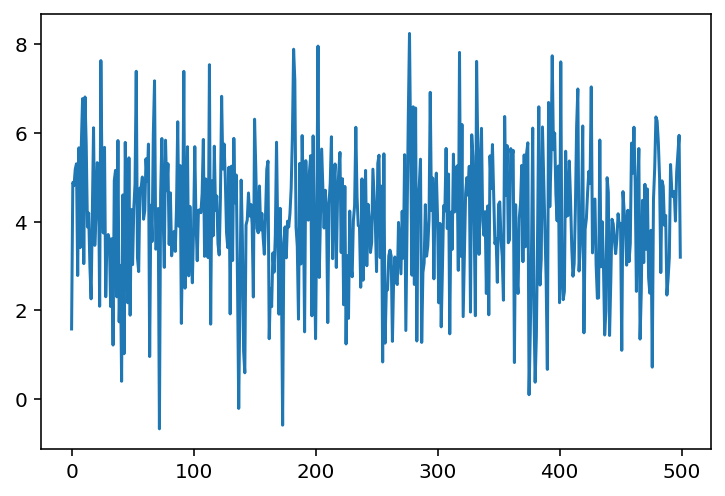

In [88]:
z = np.arange(K)

seed(314)
n_samples = 500
samples = np.zeros(n_samples)
zi = np.random.choice(z, p=pi)

for n in range(n_samples):
    Nx = norm(loc=mus[zi], scale=sigmas[zi])
    samples[n] = Nx.rvs()
    
    zi = np.random.choice(z, p=A[zi])

plt.plot(samples)